# Seq2Seq_Attension
刪除原數列中的奇數數字並將剩餘偶數數字複製一次
<br>輸入 : [9 , 4 , 1 , 4 , 8 , 5 , 8 , 3 , 7 , 5 , 8 , 10 , 5]
<br>輸出 : [4 , 4 , 8 , 8 , 8 , 10 , 4 , 4 , 8 , 8 , 8 , 10]
<br><br>
對比於「1_seq2seq_使用helper指令.ipynb」這支程式<br>
加入Attention機制強化Seq2Seq後，可以明顯發現訓練的效果比起單純Seq2Seq還要好非常多

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
from tensorflow.python.layers.core import Dense
import random
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

## Hyperameter

In [2]:
# 超參數
# Number of Epochs
epochs = 140
# RNN Size
rnn_hidden_unit = 50
# Number of Layers
num_layers = 2
# Embedding Size
encoding_embedding_size = 15
decoding_embedding_size = 15
# Learning Rate
learning_rate = 0.001

vocab_size_sorce = 10 + 1  # 1~10 + 0
vocab_size_target = 10 + 3 # 1~10 + 0 & 11 & 12
max_len = 24
batch_size = 64

## 準備數據(將數字串中的奇數刪除，並將剩下的數字再複製一遍)

In [3]:
PAD = 0
GO = 11
EOS = 12
odd_list, even_list = [1, 3, 5, 7, 9] * 10, [2, 4, 6, 8, 10] * 10

def get_batches(num_samples = batch_size , copy_sequence = True):  
    num_odds = np.random.randint(low = 1 , high = max_len//2 , size = num_samples)
    num_evens = np.random.randint(low = 1 , high = max_len//2 , size = num_samples)
    batch_len_x = num_odds + num_evens
    if copy_sequence:
        batch_len_y = num_evens * 2 + 1  # append <EOS> (or prepend <GO>)
    else:
        batch_len_y = num_evens + 1  # append <EOS> (or prepend <GO>)

    batch_max_length_x = np.max(batch_len_x)
    batch_max_length_y = np.max(batch_len_y)

    batch_data_x, batch_data_y = [], []
    for i in range(0 , num_samples):
        odds = random.sample(odd_list , num_odds[i])
        evens = random.sample(even_list , num_evens[i])
        sample_x = odds + evens
        random.shuffle(sample_x)

        sample_y = list(filter(lambda x: x % 2 == 0 , sample_x))
        if copy_sequence:
            sample_y += sample_y
        sample_x = np.r_[sample_x , [PAD] * (batch_max_length_x - len(sample_x))]
        sample_y = np.r_[sample_y , [EOS] , [PAD] * (batch_max_length_y - len(sample_y) - 1)]

        batch_data_x.append(sample_x)
        batch_data_y.append(sample_y)

    batch_data_x = np.array(batch_data_x , dtype = np.int32)
    batch_data_y = np.array(batch_data_y , dtype = np.int32)

    return batch_data_x , batch_data_y , batch_len_x , batch_len_y

## 輸入層

In [4]:
input_data = tf.placeholder(tf.int32, [None , None] , name = 'inputs')
targets = tf.placeholder(tf.int32, [None , None] , name = 'targets')
lr = tf.placeholder(tf.float32 , name = 'learning_rate')

source_sequence_length = tf.placeholder(tf.int32 , (None ,) , name = 'source_sequence_length')
target_sequence_length = tf.placeholder(tf.int32 , (None ,) , name = 'target_sequence_length')

# 決定target序列最大長度（之後target_sequence_length和source_sequence_length會作為feed_dict的參數）
max_target_sequence_length = tf.reduce_max(target_sequence_length , name = 'max_target_len')

## Encoder

In [5]:
# Encoder embedding
'''
encoder_embed_input = tf.contrib.layers.embed_sequence(input_data , source_vocab_size , encoding_embedding_size) 
                                                  ⇕ 相當於
encoder_embeddings = tf.Variable(tf.random_uniform([source_vocab_size , encoding_embedding_size]))
encoder_embed_input = tf.nn.embedding_lookup(encoder_embeddings , input_data)

若懶得寫兩行程式可以直接用tf.contrib.layers.embed_sequence這個函數
介紹 : https://www.tensorflow.org/api_docs/python/tf/contrib/layers/embed_sequence
'''
encoder_embed_input = tf.contrib.layers.embed_sequence(input_data , vocab_size_sorce , encoding_embedding_size)

# RNN cell
def get_lstm_cell(rnn_hidden_unit):
    lstm_cell = tf.contrib.rnn.LSTMCell(rnn_hidden_unit, 
                                        initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
    return lstm_cell

cell = tf.contrib.rnn.MultiRNNCell([get_lstm_cell(rnn_hidden_unit) for _ in range(num_layers)])

encoder_output, encoder_state = tf.nn.dynamic_rnn(cell, 
                                                  encoder_embed_input, 
                                                  sequence_length = source_sequence_length,
                                                  dtype = tf.float32)

## Decoder and Attention

In [6]:
# 預處理後的decoder輸入
# 在batch中每一筆data最前面加上GO，並移除最後一個字，所以每一筆data的詞的數目並無改變
ending = tf.identity(targets[: , 0:-1])
decoder_input = tf.concat([tf.fill([batch_size, 1], GO), ending], 1)

## tf.contrib.seq2seq.TrainingHelper:(Training 階段，還有其他種類的Helper)
### 訓練時採用teacher forcing，永遠把ground truth輸入給模型，不管模型前一步預測結果是否正確
此函數為Decoder端用來訓練的參數，這個函數不會把t-1階段的輸出當作t階段的輸入，而是把target中的真實質直接輸入給RNN<br>
主要參數是inputs與sequence_length，返回helper對象，可以做為Basic Decoder函數的參數
<br><br><br>

## tf.contrib.seq2seq.GreedyEmbeddingHelper:(Inference 階段，還有其他種類的Helper)
### 它和TrainingHelper的區別在於它會把把t-1階段的輸出進行embedding後再輸入給RNN，並且經過embedding層作為下一時刻的輸入
• greedy decoding：每一次把模型認為概率最大的 token 輸入給下一時間步<br>
• beam search decoding：每次保留 top k 的預測結果，解碼得到（近似） k best 序列 <br>
• sample decoding：每一步從模型預測的概率分布裏隨機采一個 token 輸入給下一時間步

In [7]:
# 1. Embedding，需要對target數據進行embedding，再傳入Decoder中的RNN
decoder_embeddings = tf.Variable(tf.random_uniform([vocab_size_target , decoding_embedding_size]))
decoder_embed_input = tf.nn.embedding_lookup(decoder_embeddings , decoder_input)

# 2. 建造Decoder中的RNN單元
def get_decoder_cell(rnn_hidden_unit):
    decoder_cell = tf.contrib.rnn.LSTMCell(rnn_hidden_unit,
                                           initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
    return decoder_cell
cell = tf.contrib.rnn.MultiRNNCell([get_decoder_cell(rnn_hidden_unit) for _ in range(num_layers)])
 
# 3. Output全連接層
output_layer = Dense(vocab_size_target ,
                     kernel_initializer = tf.truncated_normal_initializer(mean = 0.0 , stddev = 0.1))

# 4. 構造Attention 
attn_mech = tf.contrib.seq2seq.LuongAttention(num_units = rnn_hidden_unit ,
                                              memory = encoder_output ,
                                              memory_sequence_length = source_sequence_length)


attn_decoder = tf.contrib.seq2seq.AttentionWrapper(cell = cell ,
                                                   attention_mechanism = attn_mech , 
                                                   attention_layer_size = rnn_hidden_unit , 
                                                   alignment_history = True) # 可輸出Attention matrix
 
initial_state = attn_decoder.zero_state(batch_size , tf.float32).clone(cell_state = encoder_state)

# 5. Training decoder
with tf.variable_scope('decoder'):
    # tf.contrib.seq2seq.TrainingHelper即是採用Teacher Forcing的方法
    training_helper = tf.contrib.seq2seq.TrainingHelper(inputs = decoder_embed_input,
                                                        sequence_length = target_sequence_length,
                                                        time_major = False)
    
    # 構造decoder
    training_decoder = tf.contrib.seq2seq.BasicDecoder(attn_decoder,
                                                       training_helper,
                                                       initial_state,
                                                       output_layer) 
    
    training_decoder_output ,\
    training_final_state ,\
    training_final_sequence_lengths =\
    tf.contrib.seq2seq.dynamic_decode(training_decoder,                                          
                                      impute_finished = True,
                                      maximum_iterations = max_target_sequence_length)
    
    attention_matrices = training_final_state.alignment_history.stack(name = 'train_attention_matrix')
    
with tf.variable_scope('decoder' , reuse = True):
    
    tf.get_variable_scope().reuse_variables() 
    
    # 創建一個常量tensor並覆制為batch_size的大小
    start_tokens = tf.tile(tf.constant([GO] , dtype=tf.int32),
                           [batch_size] , 
                           name = 'start_tokens')
    
    # GreedyEmbeddingHelper採取argmax抽樣演算法來得到輸出id，並且經過embedding層作為下一時刻的輸入
    predicting_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(decoder_embeddings,
                                                                 start_tokens,
                                                                 EOS)
    
    predicting_decoder = tf.contrib.seq2seq.BasicDecoder(attn_decoder,
                                                         predicting_helper,
                                                         initial_state,
                                                         output_layer)
    
    predicting_decoder_output ,\
    predicting_final_state ,\
    predicting_final_sequence_lengths =\
    tf.contrib.seq2seq.dynamic_decode(predicting_decoder,
                                      impute_finished = True,
                                      maximum_iterations = max_target_sequence_length)  
    
    # 產生attention矩陣，有助於最後可視化結果
    predicting_attention_matrices = predicting_final_state.alignment_history.stack(name = 'inference_attention_matrix')  

In [8]:
# 輸出Attention matrix => [decoder_steps, batch_size, encoder_steps]
predicting_attention_matrices = predicting_final_state.alignment_history.stack(name = 'predicting_attention_matrix')     
    
training_logits = tf.identity(training_decoder_output.rnn_output , 'logits')
predicting_logits = tf.identity(predicting_decoder_output.sample_id , name='predictions')

masks = tf.sequence_mask(target_sequence_length , 
                         max_target_sequence_length, 
                         dtype = tf.float32, 
                         name = 'masks')

with tf.variable_scope('optimization'):        
    # Loss function
    cost = tf.contrib.seq2seq.sequence_loss(training_logits,
                                            targets,
                                            masks)

    # Optimizer
    optimizer = tf.train.AdamOptimizer(lr)

    # Gradient Clipping
    gradients = optimizer.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gradients if grad is not None]
    train_op = optimizer.apply_gradients(capped_gradients)

In [9]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

loss_ = []
stop_early = 0
for batch_i in range(0 , 5000):
    
    # 在每進行一個epoch前，把每個batch的index先決定出來
    pad_train_source_batch , pad_train_target_batch, train_source_length , train_target_length = get_batches()

        
    _ , loss , predicting_logits_result =\
    sess.run([train_op, cost , predicting_logits], 
             feed_dict = {input_data : pad_train_source_batch ,
                          targets : pad_train_target_batch ,
                          source_sequence_length: train_source_length , 
                          target_sequence_length : train_target_length  ,   
                          lr: learning_rate})
    
    loss_.append(loss)    
    if len(loss_) == 100:
        loss_ = np.array(loss_)
        print('\nBatch : {} \nTraining Loss : {:.3f}'.format(batch_i , loss_.mean()))
        if loss <= loss_.mean():
            print('New Record!') 
            stop_early = 0
        else:
            print('No Improvement.')
            stop_early += 1
            if stop_early == 3:
                break            
        loss_ = []
        
        print('Source : {}'.format(pad_train_source_batch[0 , :]))
        print('Target : {}'.format(pad_train_target_batch[0 , :]))
        print('Predict: {}\n'.format(predicting_logits_result[0 , :]))


Batch : 99 
Training Loss : 1.806
New Record!
Source : [ 6  9 10  7  8  7  2 10  7  7  0  0  0  0  0  0  0  0  0  0  0]
Target : [ 6 10  8  2 10  6 10  8  2 10 12  0  0  0  0  0  0  0  0  0  0  0  0]
Predict: [ 2  2  2  2  2  2  2  2  2  2  2  2  2 12  0  0  0  0  0  0  0  0  0]


Batch : 199 
Training Loss : 1.471
New Record!
Source : [8 6 8 1 6 9 2 4 1 5 7 1 7 1 3 1 0 0 0 0]
Target : [ 8  6  8  6  2  4  8  6  8  6  2  4 12  0  0  0  0  0  0  0  0  0  0]
Predict: [ 6  6  6  6  6  6  6  6  6  6  6 12  0  0  0  0  0  0  0  0  0  0  0]


Batch : 299 
Training Loss : 1.293
New Record!
Source : [ 2  5  3  4  7  9  1  9 10  3  9  6  0  0  0  0  0  0  0  0  0]
Target : [ 2  4 10  6  2  4 10  6 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Predict: [ 2  4  4  2  2  2  2 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


Batch : 399 
Training Loss : 1.191
New Record!
Source : [ 3  1  4  7  7 10  2  5  8  5  4  6  6  3  8  4  3  0  0  0  0]
Target : [ 4 10  2  8  4  6  6  8  4  4 10  2  8  4  6  


Batch : 3099 
Training Loss : 0.008
New Record!
Source : [ 2  4  8  6  4  3  6 10 10  4  7  2  6  5  0  0  0  0  0  0  0  0]
Target : [ 2  4  8  6  4  6 10 10  4  2  6  2  4  8  6  4  6 10 10  4  2  6 12]
Predict: [ 2  4  8  6  4  6 10 10  4  2  6  2  4  8  6  4  6 10 10  4  2  6 12]


Batch : 3199 
Training Loss : 0.005
New Record!
Source : [8 5 9 3 9 4 9 8 7 6 5 2 8 7 1 0 0 0 0 0 0]
Target : [ 8  4  8  6  2  8  8  4  8  6  2  8 12  0  0  0  0  0  0  0  0  0  0]
Predict: [ 8  4  8  6  2  8  8  4  8  6  2  8 12  0  0  0  0  0  0  0  0  0  0]


Batch : 3299 
Training Loss : 0.004
New Record!
Source : [10  5  3  7  7  3 10  7  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
Target : [10 10  2 10 10  2 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Predict: [10 10  2 10 10  2 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


Batch : 3399 
Training Loss : 0.003
New Record!
Source : [10  5  6  9  6  7  7  1  9  2  4  1 10  3  1  0  0  0  0  0  0]
Target : [10  6  6  2  4 10 10  6  6  2 

[4, 10, 6, 7, 8, 6, 2, 5, 9, 1, 10, 6, 9, 9, 1, 2, 2, 4, 0, 0, 0, 0]
[4, 10, 6, 8, 6, 2, 10, 6, 2, 2, 4, 4, 10, 6, 8, 6, 2, 10, 6, 2, 2, 4, 12]


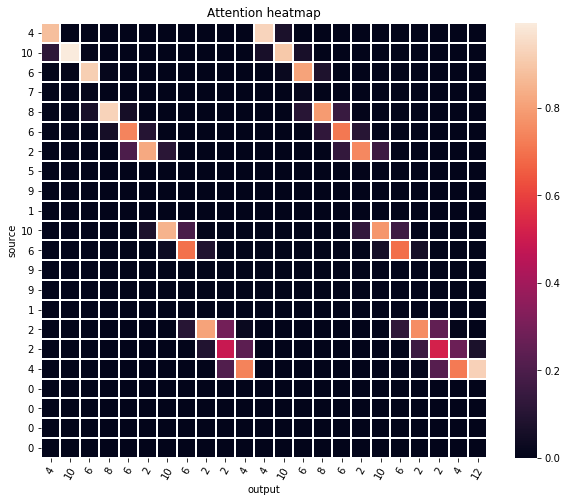

In [16]:
att , predicting_logits_ = sess.run([predicting_attention_matrices , predicting_logits], 
                                     feed_dict = {input_data : pad_train_source_batch ,
                                                  targets : pad_train_target_batch ,
                                                  source_sequence_length: train_source_length , 
                                                  target_sequence_length : train_target_length})    

# 隨機取一個樣本 i 畫出注意力矩陣
i = 50
matrix = att[:, i, :].T
src = pad_train_source_batch[i, :]
tgt = predicting_logits_[i , :]    

src_letter , tgt_letter = [] , []
for item in src:
    src_letter.append(item)
for item in tgt :
    tgt_letter.append(item)
print(src_letter)
print(tgt_letter)

df = pd.DataFrame(matrix , index = src_letter , columns = tgt_letter)
plt.figure(figsize=(10 , 8))
ax = sns.heatmap(df , linewidths = 1)
ax.set_xlabel('output')
ax.set_ylabel('source')
plt.xticks(rotation = 60)
plt.yticks(rotation = 0)
ax.set_title('Attention heatmap')
plt.show()